<a href="https://colab.research.google.com/github/iptkachev/dls_part1_project_vto/blob/master/play_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# unzip archives

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! for VARIABLE in /content/drive/MyDrive/dls_part1_project_vto/*; do echo "start $VARIABLE"; unzip -q $VARIABLE; done

start /content/drive/MyDrive/dls_part1_project_vto/models_smplx_v1_1.zip
start /content/drive/MyDrive/dls_part1_project_vto/mpips_smplify_public_v2.zip
start /content/drive/MyDrive/dls_part1_project_vto/Multi-Garmentdataset_02.zip
start /content/drive/MyDrive/dls_part1_project_vto/Multi-Garmentdataset.zip
start /content/drive/MyDrive/dls_part1_project_vto/MultiGarmentNetwork
unzip:  cannot find or open /content/drive/MyDrive/dls_part1_project_vto/MultiGarmentNetwork, /content/drive/MyDrive/dls_part1_project_vto/MultiGarmentNetwork.zip or /content/drive/MyDrive/dls_part1_project_vto/MultiGarmentNetwork.ZIP.
start /content/drive/MyDrive/dls_part1_project_vto/weights.zip


# frankmocap

In [4]:
# INSTALL ENVORIMENT

In [5]:
# download frankmocap repo and copy smpl models to repo
! git clone https://github.com/facebookresearch/frankmocap.git
! mkdir -p ./frankmocap/extra_data/smpl
! cp /content/smplify_public/code/models/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl ./frankmocap/extra_data/smpl/
! cp /content/models/smplx/SMPLX_NEUTRAL.pkl ./frankmocap/extra_data/smpl/

Cloning into 'frankmocap'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 605 (delta 96), reused 131 (delta 73), pack-reused 431
Receiving objects: 100% (605/605), 283.83 KiB | 6.45 MiB/s, done.
Resolving deltas: 100% (346/346), done.


In [6]:
# install dependencies using https://github.com/facebookresearch/frankmocap/blob/main/docs/INSTALL.md

! pip install -q torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! python -m pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
! pip install -q torchgeometry pytorch3d
! cd frankmocap && pip install -q -r docs/requirements.txt
! cd frankmocap && sh scripts/install_frankmocap.sh &> /dev/null

     |████████████████████████████████| 708.0 MB 10 kB/s 
     |████████████████████████████████| 5.9 MB 60.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
     |████████████████████████████████| 5.6 MB 8.2 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 47 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 21.7 MB/s 
     |████████████████████████████████| 112 kB 71.7 MB/s 
     |████████████████████████████████| 42 kB 948 kB/s 
     |████████████████████████████████| 30.0 MB 1.2 MB/s 
     |████████████████████████████████| 538 kB 8.1 MB/s 
     |████████████████████████████████| 1.9 MB 61.3 MB/s

In [33]:
# from google.colab.patches import cv2_imshow to frankmocap/renderer/viewer2D.py:6
# cv2_imshow(inputImg) to renderer/viewer2D.py:30

In [3]:
import os
import sys
os.chdir("/content/frankmocap")
sys.path.append("/content/frankmocap/detectors/body_pose_estimator")  # for import models.from_mobilenet
# sys.path.append("/content/frankmocap/detectors/body_pose_estimator")

In [4]:
# RUN CODE

In [5]:
class DemoOptions:

    def __init__(self):
        parser = argparse.ArgumentParser()
        
        # parser.add_argument('--checkpoint', required=False, default=default_checkpoint, help='Path to pretrained checkpoint')
        default_checkpoint_body_smpl ='./extra_data/body_module/pretrained_weights/2020_05_31-00_50_43-best-51.749683916568756.pt'
        parser.add_argument('--checkpoint_body_smpl', required=False, default=default_checkpoint_body_smpl, help='Path to pretrained checkpoint')
        default_checkpoint_body_smplx ='./extra_data/body_module/pretrained_weights/smplx-03-28-46060-w_spin_mlc3d_46582-2089_2020_03_28-21_56_16.pt'
        parser.add_argument('--checkpoint_body_smplx', required=False, default=default_checkpoint_body_smplx, help='Path to pretrained checkpoint')
        default_checkpoint_hand = "./extra_data/hand_module/pretrained_weights/pose_shape_best.pth"
        parser.add_argument('--checkpoint_hand', required=False, default=default_checkpoint_hand, help='Path to pretrained checkpoint')

        # input options
        parser.add_argument('--input_path', type=str, default=None, help="""Path of video, image, or a folder where image files exists""")
        parser.add_argument('--start_frame', type=int, default=0, help='given a sequence of frames, set the starting frame')
        parser.add_argument('--end_frame', type=int, default=float('inf'), help='given a sequence of frames, set the last frame')
        parser.add_argument('--pkl_dir', type=str, help='Path of storing pkl files that store the predicted results')
        parser.add_argument('--openpose_dir', type=str, help='Directory of storing the prediction of openpose prediction')

        # output options
        parser.add_argument('--out_dir', type=str, default=None, help='Folder of output images.')
        # parser.add_argument('--pklout', action='store_true', help='Export mocap output as pkl file')
        parser.add_argument('--save_bbox_output', action='store_true', help='Save the bboxes in json files (bbox_xywh format)')
        parser.add_argument('--save_pred_pkl', action='store_true', help='Save the predictions (bboxes, params, meshes in pkl format')
        parser.add_argument("--save_mesh", action='store_true', help="Save the predicted vertices and faces")
        parser.add_argument("--save_frame", action='store_true', help='Save the extracted frames from video input or webcam')

        # Other options
        parser.add_argument('--single_person', action='store_true', help='Reconstruct only one person in the scene with the biggest bbox')
        parser.add_argument('--no_display', action='store_true', help='Do not visualize output on the screen')
        parser.add_argument('--no_video_out', action='store_true', help='Do not merge rendered frames to video (ffmpeg)')
        parser.add_argument('--smpl_dir', type=str, default='./extra_data/smpl/', help='Folder where smpl files are located.')
        parser.add_argument('--skip', action='store_true', help='Skip there exist already processed outputs')
        parser.add_argument('--video_url', type=str, default=None, help='URL of YouTube video, or image.')
        parser.add_argument('--download', '-d', action='store_true', help='Download YouTube video first (in webvideo folder), and process it')

        # Body mocap specific options
        parser.add_argument('--use_smplx', action='store_true', help='Use SMPLX model for body mocap')

        # Hand mocap specific options
        parser.add_argument('--view_type', type=str, default='third_view', choices=['third_view', 'ego_centric'],
            help = "The view type of input. It could be ego-centric (such as epic kitchen) or third view")
        parser.add_argument('--crop_type', type=str, default='no_crop', choices=['hand_crop', 'no_crop'],
            help = """ 'hand_crop' means the hand are central cropped in input. (left hand should be flipped to right). 
                        'no_crop' means hand detection is required to obtain hand bbox""")
        
        # Whole motion capture (FrankMocap) specific options
        parser.add_argument('--frankmocap_fast_mode', action='store_true', help="Use fast hand detection mode for whole body motion capture (frankmocap)")

        # renderer
        parser.add_argument("--renderer_type", type=str, default="opengl", 
            choices=['pytorch3d', 'opendr', 'opengl_gui', 'opengl'], help="type of renderer to use")

        self.parser = parser
    

    def parse(self, *custom_args):
        self.opt = self.parser.parse_args(custom_args)
        return self.opt

In [6]:
import os
import sys
import os.path as osp
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json
import pickle
from datetime import datetime

# from demo.demo_options import DemoOptions
from bodymocap.body_mocap_api import BodyMocap
from bodymocap.body_bbox_detector import BodyPoseEstimator
import mocap_utils.demo_utils as demo_utils
import mocap_utils.general_utils as gnu
from mocap_utils.timer import Timer

import renderer.image_utils as imu
from renderer.viewer2D import ImShow

def run_body_mocap(args, body_bbox_detector, body_mocap, visualizer):
    #Setup input data to handle different types of inputs
    input_type, input_data = demo_utils.setup_input(args)

    cur_frame = args.start_frame
    video_frame = 0
    timer = Timer()
    while True:
        timer.tic()
        # load data
        load_bbox = False

        if input_type =='image_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]
                img_original_bgr  = cv2.imread(image_path)
            else:
                img_original_bgr = None

        elif input_type == 'bbox_dir':
            if cur_frame < len(input_data):
                print("Use pre-computed bounding boxes")
                image_path = input_data[cur_frame]['image_path']
                hand_bbox_list = input_data[cur_frame]['hand_bbox_list']
                body_bbox_list = input_data[cur_frame]['body_bbox_list']
                img_original_bgr  = cv2.imread(image_path)
                load_bbox = True
            else:
                img_original_bgr = None

        elif input_type == 'video':      
            _, img_original_bgr = input_data.read()
            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)

        elif input_type == 'webcam':    
            _, img_original_bgr = input_data.read()

            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"scene_{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        else:
            assert False, "Unknown input_type"

        cur_frame +=1
        if img_original_bgr is None or cur_frame > args.end_frame:
            break   
        print("--------------------------------------")

        if load_bbox:
            body_pose_list = None
        else:
            body_pose_list, body_bbox_list = body_bbox_detector.detect_body_pose(
                img_original_bgr)
        hand_bbox_list = [None, ] * len(body_bbox_list)

        # save the obtained body & hand bbox to json file
        if args.save_bbox_output: 
            demo_utils.save_info_to_json(args, image_path, body_bbox_list, hand_bbox_list)

        if len(body_bbox_list) < 1: 
            print(f"No body deteced: {image_path}")
            continue

        #Sort the bbox using bbox size 
        # (to make the order as consistent as possible without tracking)
        bbox_size =  [ (x[2] * x[3]) for x in body_bbox_list]
        idx_big2small = np.argsort(bbox_size)[::-1]
        body_bbox_list = [ body_bbox_list[i] for i in idx_big2small ]
        if args.single_person and len(body_bbox_list)>0:
            body_bbox_list = [body_bbox_list[0], ]       

        # Body Pose Regression
        pred_output_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(body_bbox_list) == len(pred_output_list)

        # extract mesh for rendering (vertices in image space and faces) from pred_output_list
        pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)

        # visualization
        res_img = visualizer.visualize(
            img_original_bgr,
            pred_mesh_list = pred_mesh_list, 
            body_bbox_list = body_bbox_list)
        
        # show result in the screen
        if not args.no_display:
            res_img = res_img.astype(np.uint8)
            ImShow(res_img)

        # save result image
        if args.out_dir is not None:
            demo_utils.save_res_img(args.out_dir, image_path, res_img)

        # save predictions to pkl
        if args.save_pred_pkl:
            demo_type = 'body'
            demo_utils.save_pred_to_pkl(
                args, demo_type, image_path, body_bbox_list, hand_bbox_list, pred_output_list)

        timer.toc(bPrint=True,title="Time")
        print(f"Processed : {image_path}")
        break

    #save images as a video
    if not args.no_video_out and input_type in ['video', 'webcam']:
        demo_utils.gen_video_out(args.out_dir, args.seq_name)

    if input_type =='webcam' and input_data is not None:
        input_data.release()
    cv2.destroyAllWindows()
    return pred_output_list, pred_mesh_list

Loading Body Pose Estimator
use_smplx False
--------------------------------------


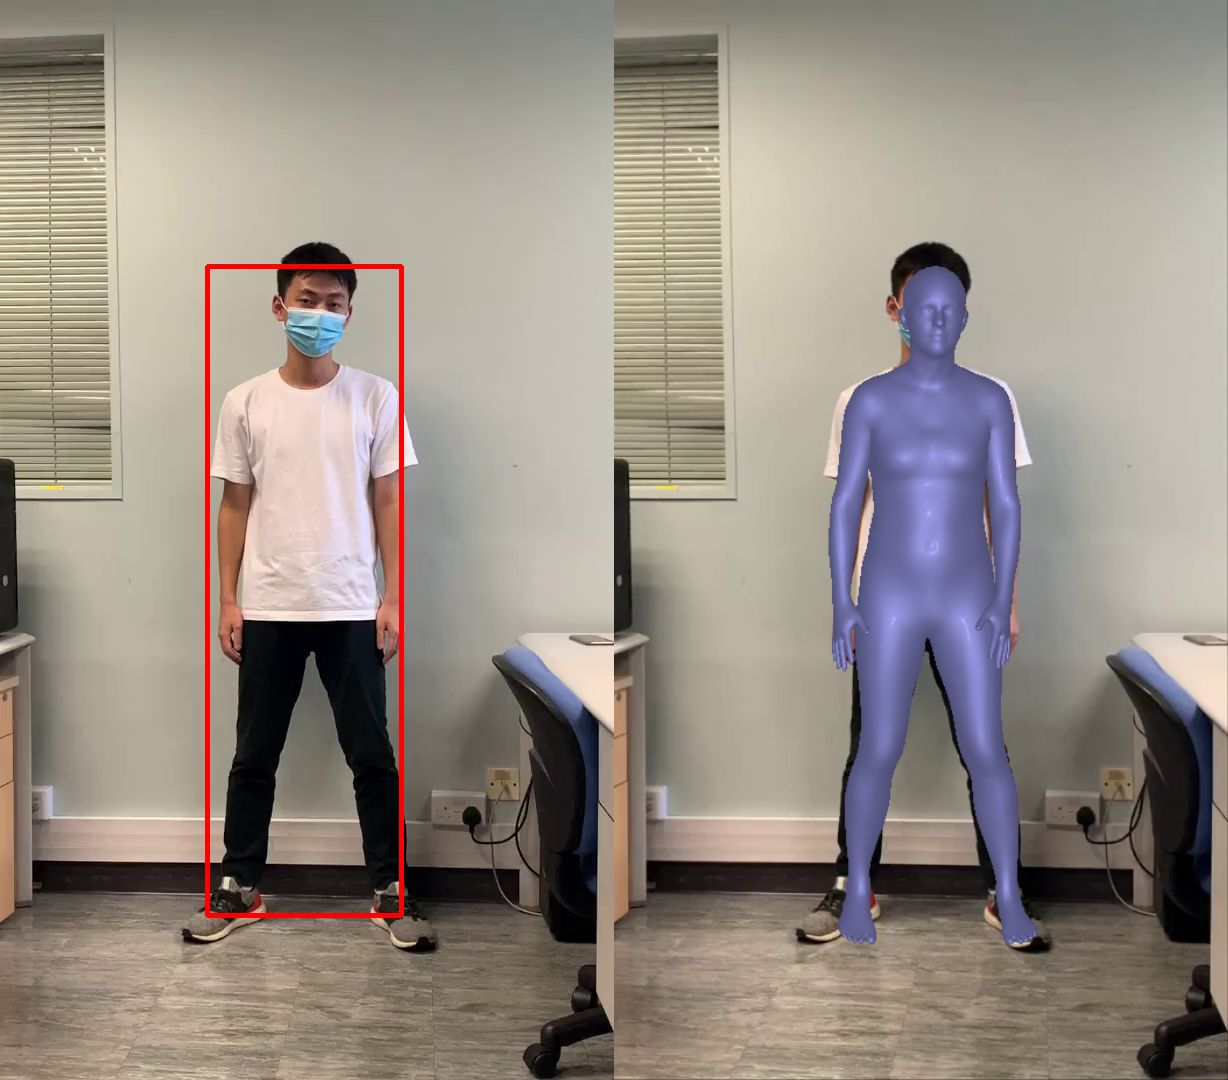

Visualization saved: ./mocap_output/rendered/00000.jpg
Time: 0.68 sec/frame, FPS 1.48
Processed : ./mocap_output/frames/00000.jpg
>> Generating video in ./mocap_output/single_totalbody.mp4


In [20]:
os.chdir("/content/frankmocap")
args = DemoOptions().parse(*[
  "--input_path", "./sample_data/single_totalbody.mp4",
  "--out_dir", "./mocap_output"
])
args.use_smplx = False
args.renderer_type = "pytorch3d"  # SET due to shutdown problem

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available(), "Current version only supports GPU"

# Set bbox detector
body_bbox_detector = BodyPoseEstimator()

# Set mocap regressor
use_smplx = args.use_smplx
checkpoint_path = args.checkpoint_body_smplx if use_smplx else args.checkpoint_body_smpl
print("use_smplx", use_smplx)
body_mocap = BodyMocap(checkpoint_path, args.smpl_dir, device, use_smplx)

# Set Visualizer
if args.renderer_type in ['pytorch3d', 'opendr']:
    from renderer.screen_free_visualizer import Visualizer
else:
    from renderer.visualizer import Visualizer
visualizer = Visualizer(args.renderer_type)
pred_output_list, pred_mesh_list = run_body_mocap(args, body_bbox_detector, body_mocap, visualizer)

In [46]:
fitted_garment.f.shape

(15180, 3)

In [153]:
pred_mesh_list[0]['faces'].shape

(13776, 3)

In [154]:
pred_mesh_list[0]['vertices'].shape

(6890, 3)

In [9]:
for k,v in pred_output_list[0].items():
  try:
    print(k, v.shape)
  except:
    pass

img_cropped (224, 224, 3)
pred_vertices_smpl (6890, 3)
pred_vertices_img (6890, 3)
pred_joints_img (49, 3)
pred_body_pose (1, 72)
pred_rotmat (1, 24, 3, 3)
pred_betas (1, 10)
pred_camera (3,)
bbox_top_left (2,)
faces (13776, 3)


In [10]:
pred_output_list[0]['pred_vertices_smpl']

array([[ 0.0703973 , -0.9563005 , -0.12278492],
       [ 0.065065  , -0.9427144 , -0.13151632],
       [ 0.07467514, -0.93796504, -0.12184423],
       ...,
       [-0.0594238 , -0.9007549 , -0.04777767],
       [-0.05946459, -0.90253425, -0.04942638],
       [-0.06187565, -0.90053844, -0.05237067]], dtype=float32)

In [53]:
fitted_garment.v

array([[ 0.04151729, -0.7308252 , -0.0746418 ],
       [ 0.05750006, -0.75151769, -0.0628921 ],
       [ 0.05480625, -0.75898607, -0.05320201],
       ...,
       [-0.1622939 , -0.55294845, -0.12960652],
       [-0.15439162, -0.54481139, -0.13737308],
       [-0.15917645, -0.5430726 , -0.12937913]])

In [54]:
fitted_garment.f

array([[1927,    1, 1924],
       [1926,    3, 1927],
       [1924,    0, 1926],
       ...,
       [6754, 1296, 5451],
       [6750, 1700, 6754],
       [6754, 5451, 6750]], dtype=uint32)

In [25]:
pred_mesh_list[0]

{'faces': array([[    3,     1,     0],
        [    7,     5,     4],
        [   12,    14,    13],
        ...,
        [ 9944, 10097, 10084],
        [ 9940, 10084, 10071],
        [10071, 10058,  9932]], dtype=int32),
 'vertices': array([[341.22858 , 320.4491  ,  -9.343572],
        [342.8176  , 321.03195 ,  -9.584915],
        [343.16882 , 320.5122  ,  -9.530876],
        ...,
        [306.85385 , 303.51068 , -37.550014],
        [307.62357 , 303.4438  , -36.972755],
        [308.49225 , 303.36514 , -36.557198]], dtype=float32)}

In [27]:
pred_mesh_list[0]['faces'].shape

(20908, 3)

In [26]:
pred_mesh_list[0]['vertices'].shape

(10475, 3)

#MultiGarmentNetwork



In [7]:
import os
os.chdir("/content")

In [13]:
! git clone https://github.com/bharat-b7/MultiGarmentNetwork.git
! cp /content/smplify_public/code/models/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl MultiGarmentNetwork/assets/neutral_smpl.pkl

Cloning into 'MultiGarmentNetwork'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 101 (delta 0), reused 1 (delta 0), pack-reused 98
Receiving objects: 100% (101/101), 7.87 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [14]:
! cp -r /content/drive/MyDrive/MultiGarmentNetwork ./

In [8]:
# install Mesh Package
! sudo apt-get install libboost-dev
! git clone https://github.com/MPI-IS/mesh.git
! cd mesh; BOOST_INCLUDE_DIRS=/usr/include/boost make all

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-dev is already the newest version (1.65.1.0ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsigh

In [9]:
# install chumpy
! pip install git+https://github.com/scottandrews/chumpy.git@fe51783e0364bf1e9b705541e7d77f894dd2b1ac

  Cloning https://github.com/scottandrews/chumpy.git (to revision fe51783e0364bf1e9b705541e7d77f894dd2b1ac) to /tmp/pip-req-build-21ed6xe2
  Running command git clone -q https://github.com/scottandrews/chumpy.git /tmp/pip-req-build-21ed6xe2
  Running command git rev-parse -q --verify 'sha^fe51783e0364bf1e9b705541e7d77f894dd2b1ac'
  Running command git fetch -q https://github.com/scottandrews/chumpy.git fe51783e0364bf1e9b705541e7d77f894dd2b1ac


In [10]:
# install opendr
! sudo apt-get install libglu1-mesa-dev freeglut3-dev mesa-common-dev
! sudo apt-get install libosmesa6-dev
! pip install opendr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglu1-mesa-dev is already the newest version (9.0.0-2.1build1).
freeglut3-dev is already the newest version (2.8.1-3).
mesa-common-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-n

In [43]:
# in /content/MultiGarmentNetwork/utils/smpl_paths.py change reading pickle 
# and SMPL_PATH smpl_vt_ft_path

In [44]:
# change EVERYWHERE: cPickle to pickle

# IN /content/MultiGarmentNetwork/utils/smpl_paths.py:75
# with open(smpl_vt_ft_path, 'rb') as f:
#     u = pkl._Unpickler(f)
#     u.encoding = 'latin1'
#     p = u.load()

In [8]:
import sys
sys.path.append("/usr/lib/python3.7/site-packages")
sys.path.append("MultiGarmentNetwork")
sys.path.append("MultiGarmentNetwork/lib")
sys.path.append("/content/SMPL_python_v.1.1.0/smpl/smpl_webuser") # fix posemaker

In [22]:
from psbody.mesh import Mesh, MeshViewers
import numpy as np
import pickle as pkl
from utils.smpl_paths import SmplPaths
from lib.ch_smpl import Smpl
from utils.interpenetration_ind import remove_interpenetration_fast
from os.path import join, split
from glob import glob

def load_smpl_from_file(file):
    with open(file, 'rb') as f:
      u = pkl._Unpickler(f)
      u.encoding = 'latin1'
      dat = u.load()
    dp = SmplPaths(gender=dat['gender'])
    smpl_h = Smpl(dp.get_hres_smpl_model_data())

    smpl_h.pose[:] = dat['pose']
    smpl_h.betas[:] = dat['betas']
    smpl_h.trans[:] = dat['trans']

    return smpl_h

def pose_garment(garment, vert_indices, smpl_params):
    '''
    :param smpl_params: dict with pose, betas, v_template, trans, gender
    '''
    dp = SmplPaths(gender=smpl_params['gender'])
    smpl = Smpl(dp.get_hres_smpl_model_data() )
    smpl.pose[:] = 0
    smpl.betas[:] = smpl_params['betas']
    # smpl.v_template[:] = smpl_params['v_template']
    offsets = np.zeros_like(smpl.r)
    offsets[vert_indices] = garment.v - smpl.r[vert_indices]
    smpl.v_personal[:] = offsets
    smpl.pose[:] = smpl_params['pose']
    smpl.trans[:] = smpl_params['trans']

    mesh = Mesh(smpl.r, smpl.f).keep_vertices(vert_indices)
    return mesh

def retarget(garment_mesh, src, tgt):
    '''
    For each vertex finds the closest point and
    :return:
    '''
    from psbody.mesh import Mesh
    verts, _ = src.closest_vertices(garment_mesh.v)
    verts = np.array(verts)
    tgt_garment = garment_mesh.v + tgt.v[verts] #  - src.v[verts]
    return Mesh(tgt_garment, garment_mesh.f)

def dress(smpl_tgt, body_src, garment, vert_inds, garment_tex = None):
    '''
    :param smpl: SMPL in the output pose
    :param garment: garment mesh in t-pose
    :param body_src: garment body in t-pose
    :param garment_tex: texture file
    :param vert_inds: vertex association b/w smpl and garment
    :return:
    To use texture files, garments must have vt, ft
    '''
    tgt_params = {'pose': np.array(smpl_tgt.pose.r), 'trans': np.array(smpl_tgt.trans.r), 'betas': np.array(smpl_tgt.betas.r), 'gender': 'neutral'}
    smpl_tgt.pose[:] = 0
    body_tgt = Mesh(smpl_tgt.r, smpl_tgt.f)

    ## Re-target
    ret = retarget(garment, body_src, body_tgt)

    ## Re-pose
    ret_posed = pose_garment(ret, vert_inds, tgt_params)
    body_tgt_posed = pose_garment(body_tgt, range(len(body_tgt.v)), tgt_params)

    ## Remove intersections
    ret_posed_interp = remove_interpenetration_fast(ret_posed, body_tgt_posed)
    ret_posed_interp.vt = garment.vt
    ret_posed_interp.ft = garment.ft
    ret_posed_interp.set_texture_image(garment_tex)

    return ret_posed_interp

path = '/content/Multi-Garment_dataset/'
all_scans = glob(path + '*')
garment_classes = ['Pants', 'ShortPants', 'ShirtNoCoat', 'TShirtNoCoat', 'LongCoat']
gar_dict = {}
for gar in garment_classes:
    gar_dict[gar] = glob(join(path, '*', gar + '.obj'))

if __name__ == '__main__':
    dp = SmplPaths()
    vt, ft = dp.get_vt_ft_hres()
    smpl = Smpl(dp.get_hres_smpl_model_data())

    ## This file contains correspondances between garment vertices and smpl body
    fts_file = '/content/MultiGarmentNetwork/assets/garment_fts.pkl'
    with open(fts_file, 'rb') as f:
        u = pkl._Unpickler(f)
        u.encoding = 'latin1'
        vert_indices, fts = u.load()
    fts['naked'] = ft

    ## Choose any garmet type as source
    garment_type = 'TShirtNoCoat'
    index = np.random.randint(0, len(gar_dict[garment_type]))   ## Randomly pick from the digital wardrobe
    path = split(gar_dict[garment_type][index])[0]


    garment_org_body_unposed = load_smpl_from_file(join(path, 'registration.pkl'))
    garment_org_body_unposed.pose[:] = 0
    garment_org_body_unposed.trans[:] = 0
    garment_org_body_unposed = Mesh(garment_org_body_unposed.v, garment_org_body_unposed.f)

    garment_unposed = Mesh(filename=join(path, garment_type + '.obj'))
    garment_tex = join(path, 'multi_tex.jpg')

    ## Generate random SMPL body (Feel free to set up ur own smpl) as target subject
    smpl.pose[:] = np.random.randn(72) *0.05
    smpl.betas[:] = np.random.randn(10) *0.01
    smpl.trans[:] = 0
    tgt_body = Mesh(smpl.r, smpl.f)

    vert_inds = vert_indices[garment_type]
    garment_unposed.set_texture_image(garment_tex)

    new_garment = dress(smpl, garment_org_body_unposed, garment_unposed, vert_inds, garment_tex)

    mvs = MeshViewers((1, 2))
    mvs[0][0].set_static_meshes([garment_unposed])
    mvs[0][1].set_static_meshes([new_garment, tgt_body])

    print('Done')

Done


# Multi-Garment Network with frankmocap

In [94]:
# args = DemoOptions().parse(*[
#   "--input_path", "./sample_data/single_totalbody.mp4",
#   "--out_dir", "./mocap_output"
# ])
# args.use_smplx = True
# args.renderer_type = "pytorch3d"  # SET due to shutdown problem

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# assert torch.cuda.is_available(), "Current version only supports GPU"

# hand_bbox_detector =  HandBboxDetector('third_view', device)

# #Set Mocap regressor
# body_mocap = BodyMocap(args.checkpoint_body_smplx, args.smpl_dir, device = device, use_smplx= True)
# hand_mocap = HandMocap(args.checkpoint_hand, args.smpl_dir, device = device)

# # Set Visualizer
# if args.renderer_type in ['pytorch3d', 'opendr']:
#     from renderer.screen_free_visualizer import Visualizer
# else:
#     from renderer.visualizer import Visualizer
# visualizer = Visualizer(args.renderer_type)

# pred_mesh_list = run_frank_mocap(args, hand_bbox_detector, body_mocap, hand_mocap, visualizer)

In [24]:
import os
def get_gar_dict():
    from glob import glob
    path = '/content/Multi-Garment_dataset/'
    # path = '/Users/i.tkachev/Downloads/Multi-Garment_dataset/'
    all_scans = glob(path + '*')
    garment_classes = ['Pants', 'ShortPants', 'ShirtNoCoat', 'TShirtNoCoat', 'LongCoat']
    gar_dict = {}
    for gar in garment_classes:
        gar_dict[gar] = glob(join(path, '*', gar + '.obj'))
    return gar_dict


def read_garment_unposed(path, garment_type):
    garment_org_body_unposed = load_smpl_from_file(join(path, 'registration.pkl'))
    garment_org_body_unposed.pose[:] = 0
    garment_org_body_unposed.trans[:] = 0
    garment_org_body_unposed = Mesh(garment_org_body_unposed.v, garment_org_body_unposed.f)

    garment_unposed = Mesh(filename=join(path, garment_type + '.obj'))
    garment_tex = join(path, 'multi_tex.jpg')
    return garment_org_body_unposed, garment_unposed, garment_tex


def get_smpl(betas, body_pose):
    from utils.smpl_paths import SmplPaths
    from lib.ch_smpl import Smpl
    dp = SmplPaths()
    smpl = Smpl(dp.get_hres_smpl_model_data())

    smpl.pose[:] = body_pose
    smpl.betas[:] = betas
    smpl.trans[:] = 0
    return smpl


def dress_frankmocap(betas, body_pose):
    """
    betas - np.array[10]
    body_pose - np.array[72]
    """
    smpl = get_smpl(betas, body_pose)
    ## This file contains correspondances between garment vertices and smpl body
    fts_file = '/content/MultiGarmentNetwork/assets/garment_fts.pkl'
    # fts_file = 'assets/garment_fts.pkl'
    with open(fts_file, 'rb') as f:
        u = pkl._Unpickler(f)
        u.encoding = 'latin1'
        vert_indices, fts = u.load()
    garment_type = 'TShirtNoCoat'
    vert_inds = vert_indices[garment_type]

    gar_dict = get_gar_dict()
    index = 3  # np.random.randint(0, len(gar_dict[garment_type]))   ## Randomly pick from the digital wardrobe
    path = os.path.split(gar_dict[garment_type][index])[0]
    garment_org_body_unposed, garment_unposed, garment_tex = read_garment_unposed(path, garment_type)
    garment_unposed.set_texture_image(garment_tex)

    new_garment = dress(smpl, garment_org_body_unposed, garment_unposed, vert_inds, garment_tex)
    mvs = MeshViewers((1, 1))
    mvs[0][0].set_static_meshes([new_garment])
    print('Done')
    return new_garment


body_pose = np.array([-3.12697315e+00, -1.79034267e-02,  9.48987007e-02,
    -2.37005785e-01,  4.90646847e-02,  1.42429829e-01,
    -1.85178131e-01, -5.37897646e-02, -1.39961332e-01,
      1.93478674e-01, -8.19251500e-03,  1.63578428e-02,
      3.42615753e-01, -3.65480743e-02,  2.07277425e-02,
      3.23492199e-01,  6.19088225e-02,  1.62485510e-03,
    -5.21238483e-02, -7.07053905e-03, -1.04366206e-02,
      5.32234274e-02,  1.21898875e-01, -1.82995319e-01,
      3.16073820e-02, -1.27232552e-01,  1.75047249e-01,
      1.20194154e-02,  2.67846067e-03,  3.33001808e-05,
    -1.49502918e-01,  5.77251948e-02,  2.20002681e-01,
    -1.33373424e-01, -4.27188389e-02, -2.27284640e-01,
    -1.82709470e-01,  1.00619495e-01, -4.18513529e-02,
      3.18128578e-02, -1.83230698e-01, -2.92322010e-01,
      4.71539646e-02,  1.72072470e-01,  3.22760940e-01,
      1.45341763e-02,  8.34683776e-02, -7.63424262e-02,
      1.59084663e-01, -3.56417120e-01, -1.02150393e+00,
      1.51025608e-01,  3.42710614e-01,  1.00343764e+00,
      9.59191993e-02, -3.96949470e-01,  4.15478833e-02,
      6.23470917e-02,  3.50600392e-01, -2.57463753e-02,
    -3.20234656e-01,  5.00960112e-01,  4.96578142e-02,
    -3.87665153e-01, -3.11701626e-01, -1.45087466e-01,
    -1.51315108e-01, -7.86356181e-02, -1.67638242e-01,
    -1.53269768e-01,  7.31144994e-02,  1.76872730e-01])
betas = np.array([ 0.28246278, -0.38122526,  0.9179737 , -0.4644972 , -0.61758655,
    -0.9218174 , -0.12720391,  0.19536698,  0.8556492 ,  0.2866686 ], dtype="float32")

fitted_garment = dress_frankmocap(betas, body_pose)

Done


In [34]:
fitted_garment.f.copy()

array([[1924,    1, 1927],
       [1927,    3, 1926],
       [1926,    0, 1924],
       ...,
       [5451, 1296, 6754],
       [6754, 1700, 6750],
       [6750, 5451, 6754]], dtype=uint32)

In [119]:
pred_output_list[0]['pred_vertices_img'].shape

(10475, 3)

In [41]:
fitted_garment.v.shape

(7702, 3)

In [43]:
fitted_garment.f.shape

(15180, 3)

In [46]:
fitted_garment.vt.dtype

dtype('float64')

In [44]:
fitted_garment.ft.shape

(15180, 3)

In [ ]:
fitted_garment = dress_frankmocap(betas, body_pose)

In [50]:
# Copyright (c) Facebook, Inc. and its affiliates.

import cv2
import sys
import torch
import numpy as np
import pickle
from torchvision.transforms import Normalize

from bodymocap.models import hmr, SMPL, SMPLX
from bodymocap import constants
from bodymocap.utils.imutils import crop, crop_bboxInfo, process_image_bbox, process_image_keypoints, \
    bbox_from_keypoints
from mocap_utils.coordconv import convert_smpl_to_bbox, convert_bbox_to_oriIm
import mocap_utils.geometry_utils as gu


class BodyMocap(object):
    def __init__(self, regressor_checkpoint, smpl_dir, device=torch.device('cuda'), use_smplx=False):

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # Load parametric model (SMPLX or SMPL)
        if use_smplx:
            smplModelPath = smpl_dir + '/SMPLX_NEUTRAL.pkl'
            self.smpl = SMPLX(smpl_dir,
                              batch_size=1,
                              num_betas=10,
                              use_pca=False,
                              create_transl=False).to(self.device)
            self.use_smplx = True
        else:
            smplModelPath = smpl_dir + '/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl'
            self.smpl = SMPL(smplModelPath, batch_size=1, create_transl=False).to(self.device)
            self.use_smplx = False

        # Load pre-trained neural network
        SMPL_MEAN_PARAMS = './extra_data/body_module/data_from_spin/smpl_mean_params.npz'
        self.model_regressor = hmr(SMPL_MEAN_PARAMS).to(self.device)
        checkpoint = torch.load(regressor_checkpoint)
        self.model_regressor.load_state_dict(checkpoint['model'], strict=False)
        self.model_regressor.eval()

    def regress(self, img_original, body_bbox_list):
        """
            args:
                img_original: original raw image (BGR order by using cv2.imread)
                body_bbox: bounding box around the target: (minX, minY, width, height)
            outputs:
                pred_vertices_img:
                pred_joints_vis_img:
                pred_rotmat
                pred_betas
                pred_camera
                bbox: [bbr[0], bbr[1],bbr[0]+bbr[2], bbr[1]+bbr[3]])
                bboxTopLeft:  bbox top left (redundant)
                boxScale_o2n: bbox scaling factor (redundant)
        """
        pred_output_list = list()

        for body_bbox in body_bbox_list:
            img, norm_img, boxScale_o2n, bboxTopLeft, bbox = process_image_bbox(
                img_original, body_bbox, input_res=constants.IMG_RES)
            bboxTopLeft = np.array(bboxTopLeft)

            # bboxTopLeft = bbox['bboxXYWH'][:2]
            if img is None:
                pred_output_list.append(None)
                continue

            with torch.no_grad():
                # model forward
                pred_rotmat, pred_betas, pred_camera = self.model_regressor(norm_img.to(self.device))

                # Convert rot_mat to aa since hands are always in aa
                # pred_aa = rotmat3x3_to_angle_axis(pred_rotmat)
                pred_aa = gu.rotation_matrix_to_angle_axis(pred_rotmat).cuda()
                pred_aa = pred_aa.reshape(pred_aa.shape[0], 72)
                smpl_output = self.smpl(
                    betas=pred_betas,
                    body_pose=pred_aa[:, 3:],
                    global_orient=pred_aa[:, :3],
                    pose2rot=True)
                pred_vertices = smpl_output.vertices
                pred_joints_3d = smpl_output.joints
                print()
                pred_vertices = pred_vertices[0].cpu().numpy()

                pred_camera = pred_camera.cpu().numpy().ravel()
                camScale = pred_camera[0] * 0.53
                camTrans = pred_camera[1:] * 0 # __________________________________________________________________________________________________________________________________

                pred_output = dict()
                # Convert mesh to original image space (X,Y are aligned to image)
                # 1. SMPL -> 2D bbox
                # 2. 2D bbox -> original 2D image
                pred_aa_tensor = gu.rotation_matrix_to_angle_axis(pred_rotmat.detach().cpu()[0])
                # __________________________________________________________________________________________________________________________________
                betas = pred_betas.detach().cpu().numpy().reshape(-1)
                body_pose = pred_aa_tensor.cpu().numpy().reshape(-1)
                fitted_garment = dress_frankmocap(betas, body_pose)
                # __________________________________________________________________________________________________________________________________
                if fitted_garment.v is not None:
                    pred_vertices_bbox = convert_smpl_to_bbox(fitted_garment.v, camScale, camTrans)
                    pred_vertices_texture_bbox = convert_smpl_to_bbox(fitted_garment.vt, camScale, camTrans)
                else:
                    pred_vertices_bbox = convert_smpl_to_bbox(pred_vertices, camScale, camTrans)
                    pred_vertices_texture_bbox = None

                pred_vertices_img = convert_bbox_to_oriIm(
                    pred_vertices_bbox, boxScale_o2n, bboxTopLeft, img_original.shape[1], img_original.shape[0])
                
                if pred_vertices_texture_bbox is not None:
                    pred_vertices_texture_img = convert_bbox_to_oriIm(
                        pred_vertices_texture_bbox, boxScale_o2n, bboxTopLeft, img_original.shape[1], img_original.shape[0])
                else:
                    pred_vertices_texture_img = None
                # Convert joint to original image space (X,Y are aligned to image)
                pred_joints_3d = pred_joints_3d[0].cpu().numpy()  # (1,49,3)
                pred_joints_vis = pred_joints_3d[:, :3]  # (49,3)
                pred_joints_vis_bbox = convert_smpl_to_bbox(pred_joints_vis, camScale, camTrans)
                pred_joints_vis_img = convert_bbox_to_oriIm(
                    pred_joints_vis_bbox, boxScale_o2n, bboxTopLeft, img_original.shape[1], img_original.shape[0])

                # Output
                pred_output['img_cropped'] = img[:, :, ::-1]
                pred_output['pred_vertices_smpl'] = smpl_output.vertices[
                    0].cpu().numpy()  # SMPL vertex in original smpl space
                pred_output['pred_vertices_img'] = pred_vertices_img  # SMPL vertex in image space
                pred_output['texture_vertices'] = pred_vertices_texture_img  # SMPL texture in image space
                print(pred_output['texture_vertices'])
                pred_output['pred_joints_img'] = pred_joints_vis_img  # SMPL joints in image space

                pred_output['pred_body_pose'] = pred_aa_tensor.cpu().numpy().reshape(1, 72)  # (1, 72)

                pred_output['pred_rotmat'] = pred_rotmat.detach().cpu().numpy()  # (1, 24, 3, 3)
                pred_output['pred_betas'] = pred_betas.detach().cpu().numpy()  # (1, 10)

                pred_output['pred_camera'] = pred_camera
                pred_output['bbox_top_left'] = bboxTopLeft
                pred_output['bbox_scale_ratio'] = boxScale_o2n
                if fitted_garment.f is not None:
                    pred_output['faces'] = fitted_garment.f
                else:
                    pred_output['faces'] = self.smpl.faces

                if self.use_smplx:
                    img_center = np.array((img_original.shape[1], img_original.shape[0])) * 0.5
                    # right hand
                    pred_joints = smpl_output.right_hand_joints[0].cpu().numpy()
                    pred_joints_bbox = convert_smpl_to_bbox(pred_joints, camScale, camTrans)
                    pred_joints_img = convert_bbox_to_oriIm(
                        pred_joints_bbox, boxScale_o2n, bboxTopLeft, img_original.shape[1], img_original.shape[0])
                    pred_output['right_hand_joints_img_coord'] = pred_joints_img
                    # left hand
                    pred_joints = smpl_output.left_hand_joints[0].cpu().numpy()
                    pred_joints_bbox = convert_smpl_to_bbox(pred_joints, camScale, camTrans)
                    pred_joints_img = convert_bbox_to_oriIm(
                        pred_joints_bbox, boxScale_o2n, bboxTopLeft, img_original.shape[1], img_original.shape[0])
                    pred_output['left_hand_joints_img_coord'] = pred_joints_img

                pred_output_list.append(pred_output)

        return pred_output_list

    def get_hand_bboxes(self, pred_body_list, img_shape):
        """
            args:
                pred_body_list: output of body regresion
                img_shape: img_height, img_width
            outputs:
                hand_bbox_list:
        """
        hand_bbox_list = list()
        for pred_body in pred_body_list:
            hand_bbox = dict(
                left_hand=None,
                right_hand=None
            )
            if pred_body is None:
                hand_bbox_list.append(hand_bbox)
            else:
                for hand_type in hand_bbox:
                    key = f'{hand_type}_joints_img_coord'
                    pred_joints_vis_img = pred_body[key]

                    if pred_joints_vis_img is not None:
                        # get initial bbox
                        x0, x1 = np.min(pred_joints_vis_img[:, 0]), np.max(pred_joints_vis_img[:, 0])
                        y0, y1 = np.min(pred_joints_vis_img[:, 1]), np.max(pred_joints_vis_img[:, 1])
                        width, height = x1 - x0, y1 - y0
                        # extend the obtained bbox
                        margin = int(max(height, width) * 0.2)
                        img_height, img_width = img_shape
                        x0 = max(x0 - margin, 0)
                        y0 = max(y0 - margin, 0)
                        x1 = min(x1 + margin, img_width)
                        y1 = min(y1 + margin, img_height)
                        # result bbox in (x0, y0, w, h) format
                        hand_bbox[hand_type] = np.array([x0, y0, x1 - x0, y1 - y0])  # in (x, y, w, h ) format

                hand_bbox_list.append(hand_bbox)

        return hand_bbox_list


Loading Body Pose Estimator
use_smplx True
--------------------------------------

Done
[[381.13497787 772.83058509]
 [378.62675599 769.69375229]
 [382.53737545 768.89528575]
 ...
 [307.69928507 669.21928661]
 [308.45129537 670.62707643]
 [308.22813953 673.39039281]]
None


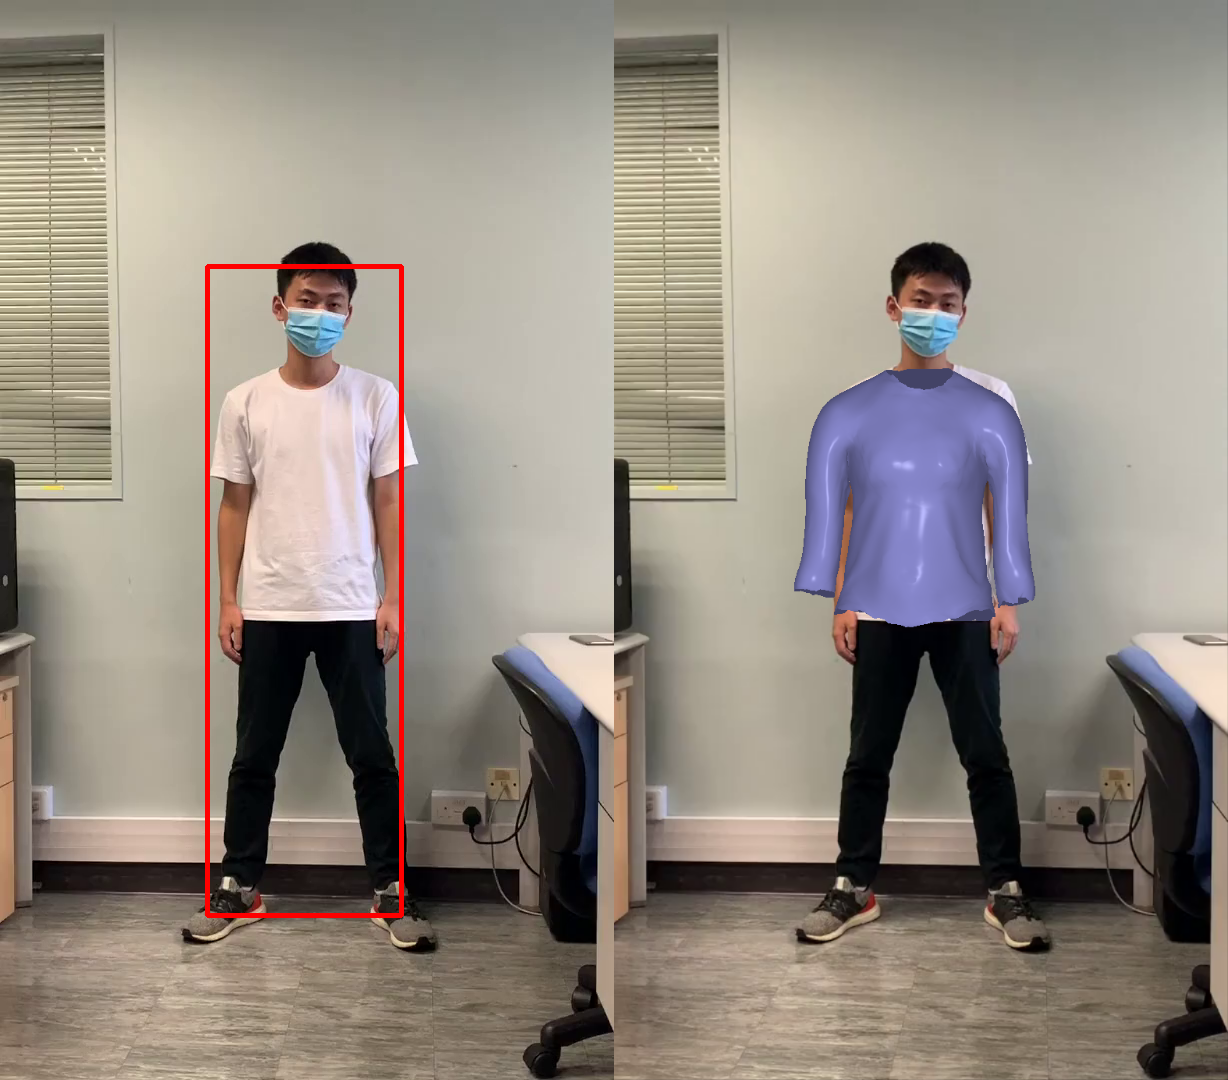

Visualization saved: ./mocap_output/rendered/00000.jpg
Time: 12.95 sec/frame, FPS 0.08
Processed : ./mocap_output/frames/00000.jpg
>> Generating video in ./mocap_output/single_totalbody.mp4


In [51]:
def extract_mesh_from_output(pred_output_list):
    pred_mesh_list = list()
    for pred_output in pred_output_list:
        if pred_output is not None:
            if 'left_hand' in pred_output: # hand mocap
                for hand_type in pred_output:
                    if pred_output[hand_type] is not None:
                        vertices = pred_output[hand_type]['pred_vertices_img']
                        faces = pred_output[hand_type]['faces'].astype(np.int32)
                        pred_mesh_list.append(dict(
                            vertices = vertices,
                            faces = faces
                        ))
            else: # body mocap (includes frank/whole/total mocap)
                vertices = pred_output['pred_vertices_img']
                faces = pred_output['faces'].astype(np.int32)
                texture_vertices = pred_output['texture_vertices'].astype(np.int32)
                pred_mesh_list.append(dict(
                    vertices = vertices,
                    faces = faces,
                    texture_vertices = texture_vertices
                ))
    return pred_mesh_list


def run_body_mocap(args, body_bbox_detector, body_mocap, visualizer):
    #Setup input data to handle different types of inputs
    input_type, input_data = demo_utils.setup_input(args)

    cur_frame = args.start_frame
    video_frame = 0
    timer = Timer()
    while True:
        timer.tic()
        # load data
        load_bbox = False

        if input_type =='image_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]
                img_original_bgr  = cv2.imread(image_path)
            else:
                img_original_bgr = None

        elif input_type == 'bbox_dir':
            if cur_frame < len(input_data):
                print("Use pre-computed bounding boxes")
                image_path = input_data[cur_frame]['image_path']
                hand_bbox_list = input_data[cur_frame]['hand_bbox_list']
                body_bbox_list = input_data[cur_frame]['body_bbox_list']
                img_original_bgr  = cv2.imread(image_path)
                load_bbox = True
            else:
                img_original_bgr = None

        elif input_type == 'video':      
            _, img_original_bgr = input_data.read()
            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)

        elif input_type == 'webcam':    
            _, img_original_bgr = input_data.read()

            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"scene_{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        else:
            assert False, "Unknown input_type"

        cur_frame +=1
        if img_original_bgr is None or cur_frame > args.end_frame:
            break   
        print("--------------------------------------")

        if load_bbox:
            body_pose_list = None
        else:
            body_pose_list, body_bbox_list = body_bbox_detector.detect_body_pose(
                img_original_bgr)
        hand_bbox_list = [None, ] * len(body_bbox_list)

        # save the obtained body & hand bbox to json file
        if args.save_bbox_output: 
            demo_utils.save_info_to_json(args, image_path, body_bbox_list, hand_bbox_list)

        if len(body_bbox_list) < 1: 
            print(f"No body deteced: {image_path}")
            continue

        #Sort the bbox using bbox size 
        # (to make the order as consistent as possible without tracking)
        bbox_size =  [ (x[2] * x[3]) for x in body_bbox_list]
        idx_big2small = np.argsort(bbox_size)[::-1]
        body_bbox_list = [ body_bbox_list[i] for i in idx_big2small ]
        if args.single_person and len(body_bbox_list)>0:
            body_bbox_list = [body_bbox_list[0], ]       

        # Body Pose Regression
        # CHANGE---------------------------------------------------------------------------------------
        pred_output_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(body_bbox_list) == len(pred_output_list)

        # extract mesh for rendering (vertices in image space and faces) from pred_output_list
        pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)

        # visualization
        res_img = visualizer.visualize(
            img_original_bgr,
            pred_mesh_list = pred_mesh_list, 
            body_bbox_list = body_bbox_list)
        
        # show result in the screen
        if not args.no_display:
            res_img = res_img.astype(np.uint8)
            ImShow(res_img)

        # save result image
        if args.out_dir is not None:
            demo_utils.save_res_img(args.out_dir, image_path, res_img)

        # save predictions to pkl
        if args.save_pred_pkl:
            demo_type = 'body'
            demo_utils.save_pred_to_pkl(
                args, demo_type, image_path, body_bbox_list, hand_bbox_list, pred_output_list)

        timer.toc(bPrint=True,title="Time")
        print(f"Processed : {image_path}")
        break

    #save images as a video
    if not args.no_video_out and input_type in ['video', 'webcam']:
        demo_utils.gen_video_out(args.out_dir, args.seq_name)

    if input_type =='webcam' and input_data is not None:
        input_data.release()
    cv2.destroyAllWindows()
    return pred_output_list, pred_mesh_list



os.chdir("/content/frankmocap")
args = DemoOptions().parse(*[
  "--input_path", "./sample_data/single_totalbody.mp4",
  "--out_dir", "./mocap_output"
])
args.use_smplx = True
args.renderer_type = "pytorch3d"  # SET due to shutdown problem

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available(), "Current version only supports GPU"

# Set bbox detector
body_bbox_detector = BodyPoseEstimator()

# Set mocap regressor
use_smplx = args.use_smplx
checkpoint_path = args.checkpoint_body_smplx if use_smplx else args.checkpoint_body_smpl
print("use_smplx", use_smplx)
body_mocap = BodyMocap(checkpoint_path, args.smpl_dir, device, use_smplx)

# Set Visualizer
if args.renderer_type in ['pytorch3d', 'opendr']:
    from renderer.screen_free_visualizer import Visualizer
else:
    from renderer.visualizer import Visualizer
visualizer = Visualizer(args.renderer_type)
pred_output_list, pred_mesh_list = run_body_mocap(args, body_bbox_detector, body_mocap, visualizer)

In [52]:
for k,v in pred_output_list[0].items():
  try:
    print(k, v.shape)
  except:
    pass

img_cropped (224, 224, 3)
pred_vertices_smpl (10475, 3)
pred_vertices_img (7702, 3)
texture_vertices (28920, 2)
pred_joints_img (49, 3)
pred_body_pose (1, 72)
pred_rotmat (1, 24, 3, 3)
pred_betas (1, 10)
pred_camera (3,)
bbox_top_left (2,)
faces (15180, 3)
right_hand_joints_img_coord (21, 3)
left_hand_joints_img_coord (21, 3)


In [124]:
body_mocap.smpl.faces.shape

(20908, 3)

In [125]:
body_mocap.smpl.vertex_joint_selector.shape

ModuleAttributeError: ignored